In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import math
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import os, re, json
from pathlib import Path
import numpy as np
import pandas as pd
import soundfile as sf
from pyproj import Transformer
from scipy.signal import butter, sosfilt, find_peaks
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Load metadata
metadata_path = "/content/drive/MyDrive/ddp/gunshot-audio-all-metadata.csv"
data_dir = "/content/drive/MyDrive/ddp/ALL_gunshot"
metadata_df = pd.read_csv(metadata_path)
# Confirm type
print(type(metadata_df))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
import os
import pandas as pd

# Filter for MiniDSP UMA-8 and Raspberry Pi
filtered_df = metadata_df[
    (metadata_df["microphone"].str.contains("MiniDSP UMA-8", na=False)) &
    (metadata_df["device_manufacturer"].str.contains("Raspberry Pi", na=False))
]

# Drop duplicates to get unique UUIDs
filtered_uuids_df = filtered_df.drop_duplicates(subset=["uuid"])
uuid_list = filtered_uuids_df["uuid"].unique().tolist()

# Function to check presence of all 7 audio files
def get_valid_uuids_with_all_channels(uuid_list, data_dir):
    valid_uuids = []
    for uuid in uuid_list:
        all_exist = True
        for i in range(7):
            file_path = os.path.join(data_dir, f"{uuid}_chan{i}_v0.wav")
            if not os.path.exists(file_path):
                all_exist = False
                break
        if all_exist:
            valid_uuids.append(uuid)
    return valid_uuids

# Get the UUIDs with all 7 audio channels
valid_uuids = get_valid_uuids_with_all_channels(uuid_list, data_dir)

# Keep all rows (all channels) for valid UUIDs
filtered_metadata_all_channels = metadata_df[metadata_df['uuid'].isin(valid_uuids)]

# Save full rows per UUID
output_path = "/content/drive/MyDrive/ddp/filtered_metadata_156_all_channels.csv"
filtered_metadata_all_channels.to_csv(output_path, index=False)

print(f"Saved full channel metadata for {len(filtered_metadata_all_channels)} rows.")

Saved full channel metadata for 1346 rows.


In [ ]:
import pandas as pd
import os

# Load metadata CSV
csv_path = "/content/drive/MyDrive/ddp/filtered_metadata_156_all_channels.csv"
data_dir = "/content/drive/MyDrive/ddp/ALL_gunshot"
metadata = pd.read_csv(csv_path)

# Check if all 7-channel WAV files exist
def has_all_channels(uuid, data_dir, num_channels=7):
    return all(os.path.exists(os.path.join(data_dir, f"{uuid}_chan{i}_v0.wav")) for i in range(num_channels))

# Filter to UUIDs with all files
metadata = metadata[metadata["uuid"].apply(lambda u: has_all_channels(u, data_dir))]
uuids = metadata["uuid"].unique()


In [ ]:
# Predefined sensor (device) coordinates for each device
latlon_coords = {
    "P1":  (28.34143687, -80.7817993),
    "P17": (28.3425767, -80.78142127),
    "P19": (28.34206505, -80.78181943),
    "P20": (28.34247681, -80.78228106),
    "P21": (28.34141824, -80.78111133),
    "P18": (28.34235, -80.78161),
    "P16": (28.34219, -80.78121)
}
# Fixed source coordinates (unused for training)
source_coords = (28.34214, -80.78145)

In [ ]:
def calculate_bearing(pointA, pointB):
    """
    Calculate bearing angle from pointA (lat, lon) to pointB (lat, lon).
    Bearing is returned in degrees (0-360).
    """
    lat1 = math.radians(pointA[0])
    lon1 = math.radians(pointA[1])
    lat2 = math.radians(pointB[0])
    lon2 = math.radians(pointB[1])
    dLon = lon2 - lon1
    x = math.sin(dLon) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1) * math.cos(lat2) * math.cos(dLon))
    initial_bearing = math.atan2(x, y)
    # Convert to degrees and normalize to [0,360)
    initial_bearing = math.degrees(initial_bearing)
    bearing = (initial_bearing + 360) % 360
    return bearing

In [ ]:
class GunshotDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        if isinstance(csv_file, str):
            self.metadata = pd.read_csv(csv_file)
        else:
            self.metadata = csv_file.copy()

        self.img_dir = img_dir
        self.transform = transform

        # Filter only rows with filenames containing '_chan' and NOT '_mean'
        self.metadata = self.metadata[
            self.metadata['filename'].astype(str).str.contains('_chan') &
            ~self.metadata['filename'].astype(str).str.contains('_mean')
        ]

        # Keep only rows where the corresponding image file exists
        self.metadata = self.metadata[
            self.metadata['filename'].apply(lambda x: os.path.isfile(os.path.join(self.img_dir, str(x) + '.png')))
        ]

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        filename = str(row['filename']) + '.png'
        img_path = os.path.join(self.img_dir, filename) #loads image and converts to grayscale
        image = Image.open(img_path).convert('L')  # grayscale
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image) #image to pytorch tensor
        doa_angle = float(row['true_doa_angle'])  # convert string to float
        label = torch.tensor([doa_angle / 360.0], dtype=torch.float32)
        return image, label # image, normalized doa angle

In [ ]:
#Directory paths (set these to your actual paths)
img_dir = '/content/drive/MyDrive/ddp/mel-spectrograms/'  # Spectrogram images directory
csv_file = '/content/drive/MyDrive/ddp/filtered_metadata_156_all_channels_DOA.csv'  # Metadata CSV file
csv_doa = pd.read_csv(csv_file)

In [ ]:
batch_size = 32
num_epochs = 48
learning_rate = 0.001

# Image transform: convert PIL image to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load dataset
full_dataset = GunshotDataset(csv_file=csv_file, img_dir=img_dir, transform=transform)

# Split dataset into train/test (80/20 split)
dataset_size = len(full_dataset)
indices = list(range(dataset_size))
split = int(0.2 * dataset_size)
torch.manual_seed(42)
indices = torch.randperm(dataset_size).tolist()
train_indices, test_indices = indices[split:], indices[:split]

train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
test_dataset = torch.utils.data.Subset(full_dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DOA_CNN(nn.Module):
    def __init__(self):
        super(DOA_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # (1, 128, 173) -> (32, 128, 173) #(128,173)-freq bins, time-stamps-height and width of mel-spect
        self.pool = nn.MaxPool2d(2, 2)  # halves spatial dims, to reduce computation
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # (64, 64, 86)

        self.flatten_size = 64 * 32 * 43  # calculated manually
        self.fc1 = nn.Linear(self.flatten_size, 128) #dense layer; flatten size --> 128
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)  # Output is DOA angle in range 0 to 1(normalized_angle = angle / 360.0), dense layer; 128-->1
        self.output_act = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.conv1(x))   # (N, 32, 128, 173) #activation function to add non-linearity to conv1
        x = self.pool(x)            # (N, 32, 64, 86)
        x = F.relu(self.conv2(x))   # (N, 64, 64, 86)
        x = self.pool(x)            # (N, 64, 32, 43)
        x = x.view(-1, self.flatten_size)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return self.output_act(x)


device = torch.device('cpu')
model = DOA_CNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Training loop (48 epochs)
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images) #predicted doa angle
        loss = criterion(outputs, labels.view(-1, 1))  # reshape to [N, 1]
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [1/48], Loss: 0.1042
Epoch [2/48], Loss: 0.0843
Epoch [3/48], Loss: 0.0646
Epoch [4/48], Loss: 0.0468
Epoch [5/48], Loss: 0.0324
Epoch [6/48], Loss: 0.0246
Epoch [7/48], Loss: 0.0214
Epoch [8/48], Loss: 0.0176
Epoch [9/48], Loss: 0.0134
Epoch [10/48], Loss: 0.0112
Epoch [11/48], Loss: 0.0082
Epoch [12/48], Loss: 0.0071
Epoch [13/48], Loss: 0.0058
Epoch [14/48], Loss: 0.0058
Epoch [15/48], Loss: 0.0046
Epoch [16/48], Loss: 0.0041
Epoch [17/48], Loss: 0.0035
Epoch [18/48], Loss: 0.0034
Epoch [19/48], Loss: 0.0032
Epoch [20/48], Loss: 0.0031
Epoch [21/48], Loss: 0.0029
Epoch [22/48], Loss: 0.0029
Epoch [23/48], Loss: 0.0023
Epoch [24/48], Loss: 0.0028
Epoch [25/48], Loss: 0.0023
Epoch [26/48], Loss: 0.0023
Epoch [27/48], Loss: 0.0021
Epoch [28/48], Loss: 0.0020
Epoch [29/48], Loss: 0.0022
Epoch [30/48], Loss: 0.0019
Epoch [31/48], Loss: 0.0020
Epoch [32/48], Loss: 0.0019
Epoch [33/48], Loss: 0.0019
Epoch [34/48], Loss: 0.0022
Epoch [35/48], Loss: 0.0017
Epoch [36/48], Loss: 0.0016
E

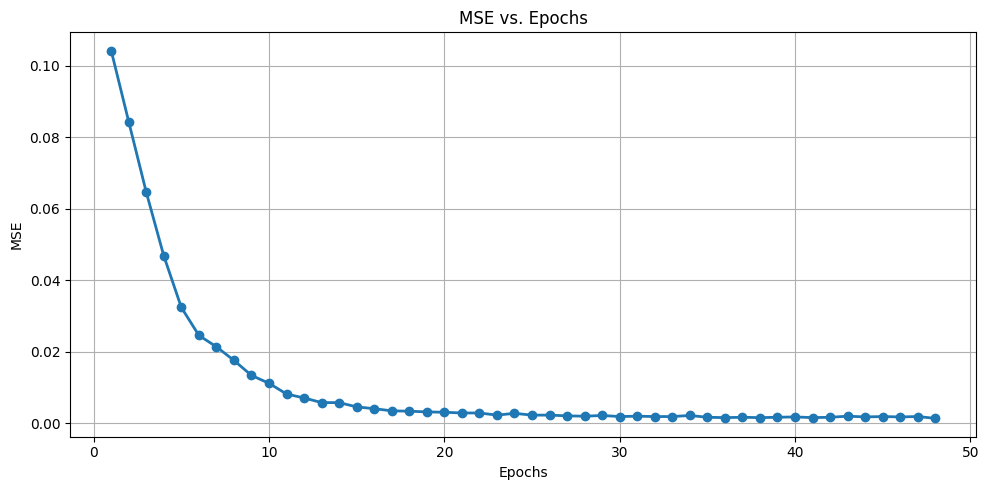

In [ ]:
import matplotlib.pyplot as plt

# Loss values extracted from the log
loss_values = [
    0.1042, 0.0843, 0.0646, 0.0468, 0.0324, 0.0246, 0.0214, 0.0176,
    0.0134, 0.0112, 0.0082, 0.0071, 0.0058, 0.0058, 0.0046, 0.0041,
    0.0035, 0.0034, 0.0032, 0.0031, 0.0029, 0.0029, 0.0023, 0.0028,
    0.0023, 0.0023, 0.0021, 0.0020, 0.0022, 0.0019, 0.0020, 0.0019,
    0.0019, 0.0022, 0.0017, 0.0016, 0.0017, 0.0016, 0.0017, 0.0018,
    0.0016, 0.0017, 0.0020, 0.0018, 0.0019, 0.0018, 0.0019, 0.0014
]

epochs = list(range(1, len(loss_values) + 1))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, marker='o', linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("MSE vs. Epochs")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Given MSE loss values per epoch
mse_losses = [
    0.1042, 0.0843, 0.0646, 0.0468, 0.0324, 0.0246, 0.0214, 0.0176,
    0.0134, 0.0112, 0.0082, 0.0071, 0.0058, 0.0058, 0.0046, 0.0041,
    0.0035, 0.0034, 0.0032, 0.0031, 0.0029, 0.0029, 0.0023, 0.0028,
    0.0023, 0.0023, 0.0021, 0.0020, 0.0022, 0.0019, 0.0020, 0.0019,
    0.0019, 0.0022, 0.0017, 0.0016, 0.0017, 0.0016, 0.0017, 0.0018,
    0.0016, 0.0017, 0.0020, 0.0018, 0.0019, 0.0018, 0.0019, 0.0014
]

# Compute RMSE values
rmse_values = [np.sqrt(mse) for mse in mse_losses]

# Print RMSE for each epoch
for epoch, rmse in enumerate(rmse_values, 1):
    print(f"Epoch {epoch}: RMSE = {rmse:.4f}")

Epoch 1: RMSE = 0.3228
Epoch 2: RMSE = 0.2903
Epoch 3: RMSE = 0.2542
Epoch 4: RMSE = 0.2163
Epoch 5: RMSE = 0.1800
Epoch 6: RMSE = 0.1568
Epoch 7: RMSE = 0.1463
Epoch 8: RMSE = 0.1327
Epoch 9: RMSE = 0.1158
Epoch 10: RMSE = 0.1058
Epoch 11: RMSE = 0.0906
Epoch 12: RMSE = 0.0843
Epoch 13: RMSE = 0.0762
Epoch 14: RMSE = 0.0762
Epoch 15: RMSE = 0.0678
Epoch 16: RMSE = 0.0640
Epoch 17: RMSE = 0.0592
Epoch 18: RMSE = 0.0583
Epoch 19: RMSE = 0.0566
Epoch 20: RMSE = 0.0557
Epoch 21: RMSE = 0.0539
Epoch 22: RMSE = 0.0539
Epoch 23: RMSE = 0.0480
Epoch 24: RMSE = 0.0529
Epoch 25: RMSE = 0.0480
Epoch 26: RMSE = 0.0480
Epoch 27: RMSE = 0.0458
Epoch 28: RMSE = 0.0447
Epoch 29: RMSE = 0.0469
Epoch 30: RMSE = 0.0436
Epoch 31: RMSE = 0.0447
Epoch 32: RMSE = 0.0436
Epoch 33: RMSE = 0.0436
Epoch 34: RMSE = 0.0469
Epoch 35: RMSE = 0.0412
Epoch 36: RMSE = 0.0400
Epoch 37: RMSE = 0.0412
Epoch 38: RMSE = 0.0400
Epoch 39: RMSE = 0.0412
Epoch 40: RMSE = 0.0424
Epoch 41: RMSE = 0.0400
Epoch 42: RMSE = 0.0412
E

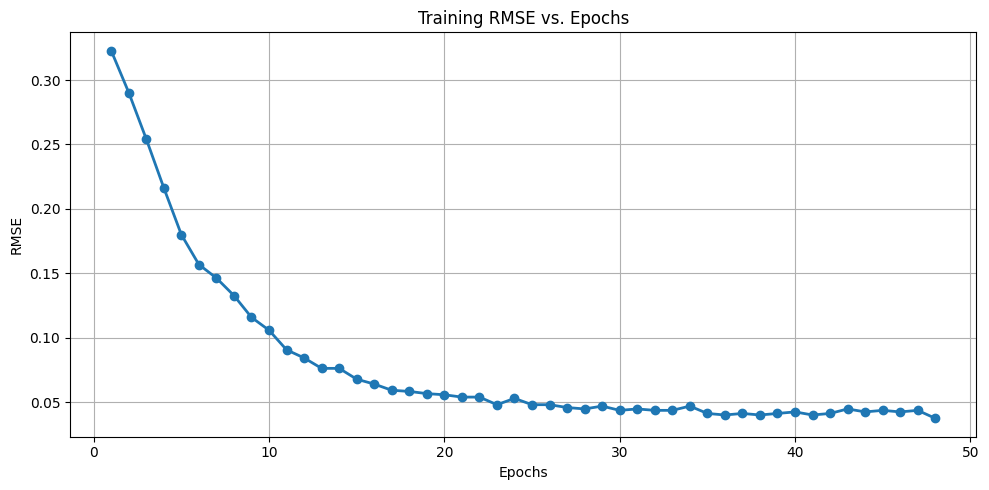

In [ ]:
import matplotlib.pyplot as plt

# RMSE values per epoch
rmse_values = [
    0.3228, 0.2903, 0.2542, 0.2163, 0.1800, 0.1568, 0.1463, 0.1327,
    0.1158, 0.1058, 0.0906, 0.0843, 0.0762, 0.0762, 0.0678, 0.0640,
    0.0592, 0.0583, 0.0566, 0.0557, 0.0539, 0.0539, 0.0480, 0.0529,
    0.0480, 0.0480, 0.0458, 0.0447, 0.0469, 0.0436, 0.0447, 0.0436,
    0.0436, 0.0469, 0.0412, 0.0400, 0.0412, 0.0400, 0.0412, 0.0424,
    0.0400, 0.0412, 0.0447, 0.0424, 0.0436, 0.0424, 0.0436, 0.0374
]

epochs = list(range(1, len(rmse_values) + 1))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, rmse_values, marker='o', linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("Training RMSE vs. Epochs")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate on test set
model.eval()
test_loss = 0.0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
test_loss = test_loss / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.0008


accounts for an error of ~15meters

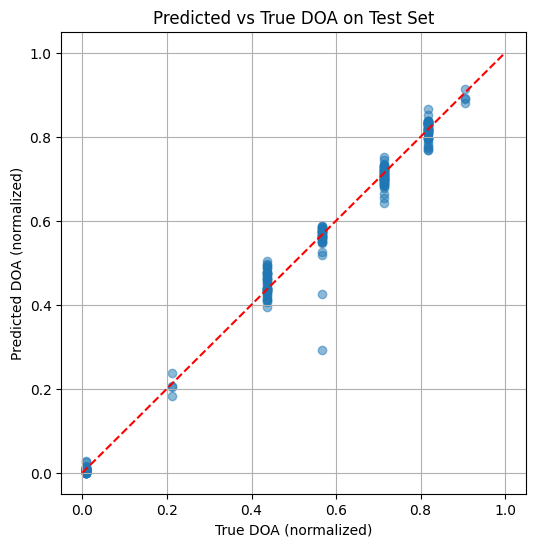

In [ ]:
import torch
import matplotlib.pyplot as plt

# Put model in evaluation mode
model.eval()

# Prepare arrays to store predictions and true values
predicted_doas = []
true_doas = []

# No gradient needed during inference
with torch.no_grad():
    for images, labels in test_loader:
        # Forward pass
        outputs = model(images)
        predicted_doas.extend(outputs.squeeze().cpu().numpy())
        true_doas.extend(labels.squeeze().cpu().numpy())

# Convert to numpy arrays
predicted_doas = np.array(predicted_doas)
true_doas = np.array(true_doas)

# Plot predicted vs true DOA
plt.figure(figsize=(6,6))
plt.scatter(true_doas, predicted_doas, alpha=0.5)
plt.plot([0,1],[0,1], 'r--')
plt.xlabel('True DOA (normalized)')
plt.ylabel('Predicted DOA (normalized)')
plt.title('Predicted vs True DOA on Test Set')
plt.grid()
plt.show()

In [ ]:
# Assuming `model`, `test_loader`, and `device` are already defined

model.eval()
print("Predicted DOA vs True DOA:")
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        preds = outputs.squeeze().cpu().numpy()
        trues = labels.squeeze().cpu().numpy()

        # If single sample, make sure they are arrays
        if np.ndim(preds) == 0:
            preds = np.array([preds])
            trues = np.array([trues])

        for i, (preds, trues) in enumerate(zip(predicted_doas, true_doas)):
            print(f"Predicted DOA: {preds:.6f}, True DOA: {trues:.6f}")

Predicted DOA vs True DOA:
Predicted DOA: 0.447304, True DOA: 0.437667
Predicted DOA: 0.009679, True DOA: 0.009205
Predicted DOA: 0.431750, True DOA: 0.437667
Predicted DOA: 0.816685, True DOA: 0.818681
Predicted DOA: 0.000062, True DOA: 0.009205
Predicted DOA: 0.552592, True DOA: 0.565601
Predicted DOA: 0.817020, True DOA: 0.818681
Predicted DOA: 0.826986, True DOA: 0.818681
Predicted DOA: 0.473180, True DOA: 0.437667
Predicted DOA: 0.768069, True DOA: 0.818681
Predicted DOA: 0.207081, True DOA: 0.213007
Predicted DOA: 0.433032, True DOA: 0.437667
Predicted DOA: 0.678792, True DOA: 0.713943
Predicted DOA: 0.000508, True DOA: 0.009205
Predicted DOA: 0.830567, True DOA: 0.818681
Predicted DOA: 0.004399, True DOA: 0.009205
Predicted DOA: 0.819267, True DOA: 0.818681
Predicted DOA: 0.583607, True DOA: 0.565601
Predicted DOA: 0.003865, True DOA: 0.009205
Predicted DOA: 0.465939, True DOA: 0.437667
Predicted DOA: 0.779276, True DOA: 0.818681
Predicted DOA: 0.437329, True DOA: 0.437667
Predi

In [ ]:
def predict_for_uuid(model, uuid, metadata, img_dir, device):
    # Filter only chan0 to avoid duplicates across channels
    row = metadata[
        (metadata['uuid'] == uuid) &
        (metadata['filename'].astype(str).str.contains('_chan0'))
    ]

    if row.empty:
        print(f"No matching entry for UUID {uuid} with chan0.")
        return

    row = row.iloc[0]
    filename = row['filename']

    # Correctly retrieve true DOA
    if 'true_doa_angle' not in row:
        print(f"'true_doa_angle' not found in metadata for UUID {uuid}")
        return

    doa_angle = float(row['true_doa_angle'])
    img_path = os.path.join(img_dir, f"{filename}.png")

    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        return

    image = Image.open(img_path).convert('L')
    image = transforms.ToTensor()(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        pred_normalized = output.item()
        pred_doa = pred_normalized * 360.0

    print(f"UUID: {uuid}")
    print(f"Predicted DOA: {pred_doa:.6f}°")
    print(f"True DOA     : {doa_angle:.6f}°")

In [ ]:
print(metadata.columns)
print(csv_doa.columns)

Index(['filename', 'uuid', 'label', 'recording_session ', 'timestamp',
       'time_offset_s', 'device_name', 'device_manufacturer', 'device_model',
       'microphone', 'firearm', 'caliber', 'latitude', 'longitude',
       'gunshot_location_in_seconds', 'num_gunshots'],
      dtype='object')
Index(['filename', 'uuid', 'label', 'recording_session ', 'timestamp',
       'time_offset_s', 'device_name', 'device_manufacturer', 'device_model',
       'microphone', 'firearm', 'caliber', 'latitude', 'longitude',
       'gunshot_location_in_seconds', 'num_gunshots', 'true_doa_angle'],
      dtype='object')


In [ ]:
uuid_to_test = 'bb5a8b3f-3724-456e-83e1-55f5ca5ac68a' #glock
predict_for_uuid(model, uuid_to_test, csv_doa, img_dir, device)

uuid_to_test = 'a283ea70-649d-4c18-bf8b-ba4e8507455a' #glock
predict_for_uuid(model, uuid_to_test, csv_doa, img_dir, device)

uuid_to_test = 'ea3ba9e7-1b6a-4ba1-afff-bc3543d9a61d' #smith
predict_for_uuid(model, uuid_to_test, csv_doa, img_dir, device)

uuid_to_test = 'eafb4d3c-bf69-49de-92fb-436003c27742' #smith
predict_for_uuid(model, uuid_to_test, csv_doa, img_dir, device)

UUID: bb5a8b3f-3724-456e-83e1-55f5ca5ac68a
Predicted DOA: 204.901757°
True DOA     : 203.616499°
UUID: a283ea70-649d-4c18-bf8b-ba4e8507455a
Predicted DOA: 2.897394°
True DOA     : 3.313864°
UUID: ea3ba9e7-1b6a-4ba1-afff-bc3543d9a61d
Predicted DOA: 257.140782°
True DOA     : 257.019472°
UUID: eafb4d3c-bf69-49de-92fb-436003c27742
Predicted DOA: 294.092224°
True DOA     : 294.725145°


In [ ]:
uuid_to_test = 'fe18216b-56d4-478a-9ed7-a3543a9930e0' #smith
predict_for_uuid(model, uuid_to_test, csv_doa, img_dir, device)

uuid_to_test = '1a1db5f5-080b-4b6d-9c77-0fe675aed427' #smith
predict_for_uuid(model, uuid_to_test, csv_doa, img_dir, device)

uuid_to_test = '3ab0f1bb-f7fe-4cfe-a78e-11a263f75819' #smith
predict_for_uuid(model, uuid_to_test, csv_doa, img_dir, device)

uuid_to_test = 'adca0472-ee71-44c9-a22d-ee86d7bb85a6' #smith
predict_for_uuid(model, uuid_to_test, csv_doa, img_dir, device)

UUID: fe18216b-56d4-478a-9ed7-a3543a9930e0
Predicted DOA: 208.718369°
True DOA     : 203.616499°
UUID: 1a1db5f5-080b-4b6d-9c77-0fe675aed427
Predicted DOA: 4.232661°
True DOA     : 3.313864°
UUID: 3ab0f1bb-f7fe-4cfe-a78e-11a263f75819
Predicted DOA: 256.506751°
True DOA     : 257.019472°
UUID: adca0472-ee71-44c9-a22d-ee86d7bb85a6
Predicted DOA: 294.775007°
True DOA     : 294.725145°


In [ ]:
uuid_to_test = 'e9b3d683-c7ec-4e77-9d3b-963d30d641f7' #ruger
predict_for_uuid(model, uuid_to_test, csv_doa, img_dir, device)

uuid_to_test = '6f48638e-2508-467e-89c7-34648cfd0699' #smith
predict_for_uuid(model, uuid_to_test, csv_doa, img_dir, device)

uuid_to_test = '2567b43f-28b3-4df1-9c7c-aae01a354755' #smith
predict_for_uuid(model, uuid_to_test, csv_doa, img_dir, device)

uuid_to_test = 'b06fc194-a76a-48c6-8ac2-937b138adf9a' #smith
predict_for_uuid(model, uuid_to_test, csv_doa, img_dir, device)


UUID: e9b3d683-c7ec-4e77-9d3b-963d30d641f7
Predicted DOA: 212.964628°
True DOA     : 203.616499°
UUID: 6f48638e-2508-467e-89c7-34648cfd0699
Predicted DOA: 2.962827°
True DOA     : 3.313864°
UUID: 2567b43f-28b3-4df1-9c7c-aae01a354755
Predicted DOA: 257.736790°
True DOA     : 257.019472°
UUID: b06fc194-a76a-48c6-8ac2-937b138adf9a
Predicted DOA: 295.938420°
True DOA     : 294.725145°


In [ ]:
uuid_to_test = 'b3247aa6-f1e5-4a0d-8330-21e3ff183567' #remington
predict_for_uuid(model, uuid_to_test, csv_doa, img_dir, device)

uuid_to_test = '5ac8c241-4728-4ba2-a6ce-8cda24399cca' #smith
predict_for_uuid(model, uuid_to_test, csv_doa, img_dir, device)

uuid_to_test = '1ad661e0-c668-444f-846e-53b74fd3b800' #smith
predict_for_uuid(model, uuid_to_test, csv_doa, img_dir, device)

uuid_to_test = '0ecc8bff-1110-42d7-9c39-06dbdd1a0075' #smith
predict_for_uuid(model, uuid_to_test, csv_doa, img_dir, device)

UUID: b3247aa6-f1e5-4a0d-8330-21e3ff183567
Predicted DOA: 210.505214°
True DOA     : 203.616499°
UUID: 5ac8c241-4728-4ba2-a6ce-8cda24399cca
Predicted DOA: 3.069518°
True DOA     : 3.313864°
UUID: 1ad661e0-c668-444f-846e-53b74fd3b800
Predicted DOA: 255.518003°
True DOA     : 257.019472°
UUID: 0ecc8bff-1110-42d7-9c39-06dbdd1a0075
Predicted DOA: 293.857670°
True DOA     : 294.725145°


In [ ]:
uuid_to_test = 'a283ea70-649d-4c18-bf8b-ba4e8507455a' #comaprison w classical method
predict_for_uuid(model, uuid_to_test, csv_doa, img_dir, device)

uuid_to_test = 'bb5a8b3f-3724-456e-83e1-55f5ca5ac68a' #comaprison w classical method
predict_for_uuid(model, uuid_to_test, csv_doa, img_dir, device)

uuid_to_test = 'd5a15ea9-1077-4e5f-80a1-c4e856231489' #comaprison w classical method
predict_for_uuid(model, uuid_to_test, csv_doa, img_dir, device)

uuid_to_test = '9480296f-8e6e-438e-a35d-76a2f24506df' #comaprison w classical method
predict_for_uuid(model, uuid_to_test, csv_doa, img_dir, device)

uuid_to_test = '9ebba20a-9b86-462a-8ac8-4cdbf2fd4a70' #comaprison w classical method
predict_for_uuid(model, uuid_to_test, csv_doa, img_dir, device)

UUID: a283ea70-649d-4c18-bf8b-ba4e8507455a
Predicted DOA: 2.897394°
True DOA     : 3.313864°
UUID: bb5a8b3f-3724-456e-83e1-55f5ca5ac68a
Predicted DOA: 204.901757°
True DOA     : 203.616499°
UUID: d5a15ea9-1077-4e5f-80a1-c4e856231489
Predicted DOA: 259.991047°
True DOA     : 257.019472°
UUID: 9480296f-8e6e-438e-a35d-76a2f24506df
Predicted DOA: 291.693063°
True DOA     : 294.725145°
UUID: 9ebba20a-9b86-462a-8ac8-4cdbf2fd4a70
Predicted DOA: 155.891415°
True DOA     : 157.560160°


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ShuffleSplit

# Define RMSE function
def compute_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Number of MCCV splits
num_splits = 3
test_size = 0.2
splitter = ShuffleSplit(n_splits=num_splits, test_size=test_size, random_state=42)

rmse_per_epoch_all = []
r2_per_epoch_all = []

for fold_idx, (train_idx, test_idx) in enumerate(splitter.split(full_dataset)):
    print(f"\n--- Fold {fold_idx + 1} ---")

    # Subset data
    train_subset = torch.utils.data.Subset(full_dataset, train_idx)
    test_subset = torch.utils.data.Subset(full_dataset, test_idx)

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_subset, batch_size=32, shuffle=False)

    # Reinitialize model and optimizer for each fold
    model = DOA_CNN()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    num_epochs = 20
    rmse_per_epoch = []
    r2_per_epoch = []

    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.view(-1, 1))  # reshape to [N, 1]
            loss.backward()
            optimizer.step()

        # Validation after each epoch
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images).squeeze()
                all_preds.extend(outputs.numpy())
                all_labels.extend(labels.squeeze().numpy())

        rmse = compute_rmse(all_labels, all_preds)
        r2 = r2_score(all_labels, all_preds)
        rmse_per_epoch.append(rmse)
        r2_per_epoch.append(r2)

        print(f"Epoch [{epoch+1}/{num_epochs}], RMSE: {rmse:.4f}, R²: {r2:.4f}")

    rmse_per_epoch_all.append(rmse_per_epoch)
    r2_per_epoch_all.append(r2_per_epoch)

In [ ]:
# Convert to numpy arrays
rmse_array = np.array(rmse_per_epoch_all)
r2_array = np.array(r2_per_epoch_all)

# Mean across folds
mean_rmse = np.mean(rmse_array, axis=0)
mean_r2 = np.mean(r2_array, axis=0)

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(mean_rmse, label='Avg RMSE')
plt.title("RMSE per Epoch (Monte Carlo CV)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(mean_r2, label='Avg R²', color='green')
plt.title("R² per Epoch (Monte Carlo CV)")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Save the model weights
torch.save(model.state_dict(), '/content/drive/MyDrive/ddp/DOA_CNN_model.pth')

# To load in another notebook
# from model_def import DOA_CNN  # if you saved the model class elsewhere
model = DOA_CNN()
model.load_state_dict(torch.load('/content/drive/MyDrive/ddp/DOA_CNN_model.pth'))
model.eval()

In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/CNN_doa_DDP2.ipynb" "/content/drive/MyDrive/ddp/CNN_doa_DDP2_saved.ipynb"

In [ ]:
!jupyter nbconvert --to script /content/drive/MyDrive/ddp/CNN_doa_DDP2.ipynb
